* Dr. Héctor Henríquez Leighton
* Santiago, 9 de octubre 2025
* CChR2025


# **Workshop evaluación y detección de sesgos de modelos de Deep Learning**







## Dataset

* Usaremos una muestra del conjunto de datos PADCHEST

https://bimcv.cipf.es/bimcv-projects/padchest/

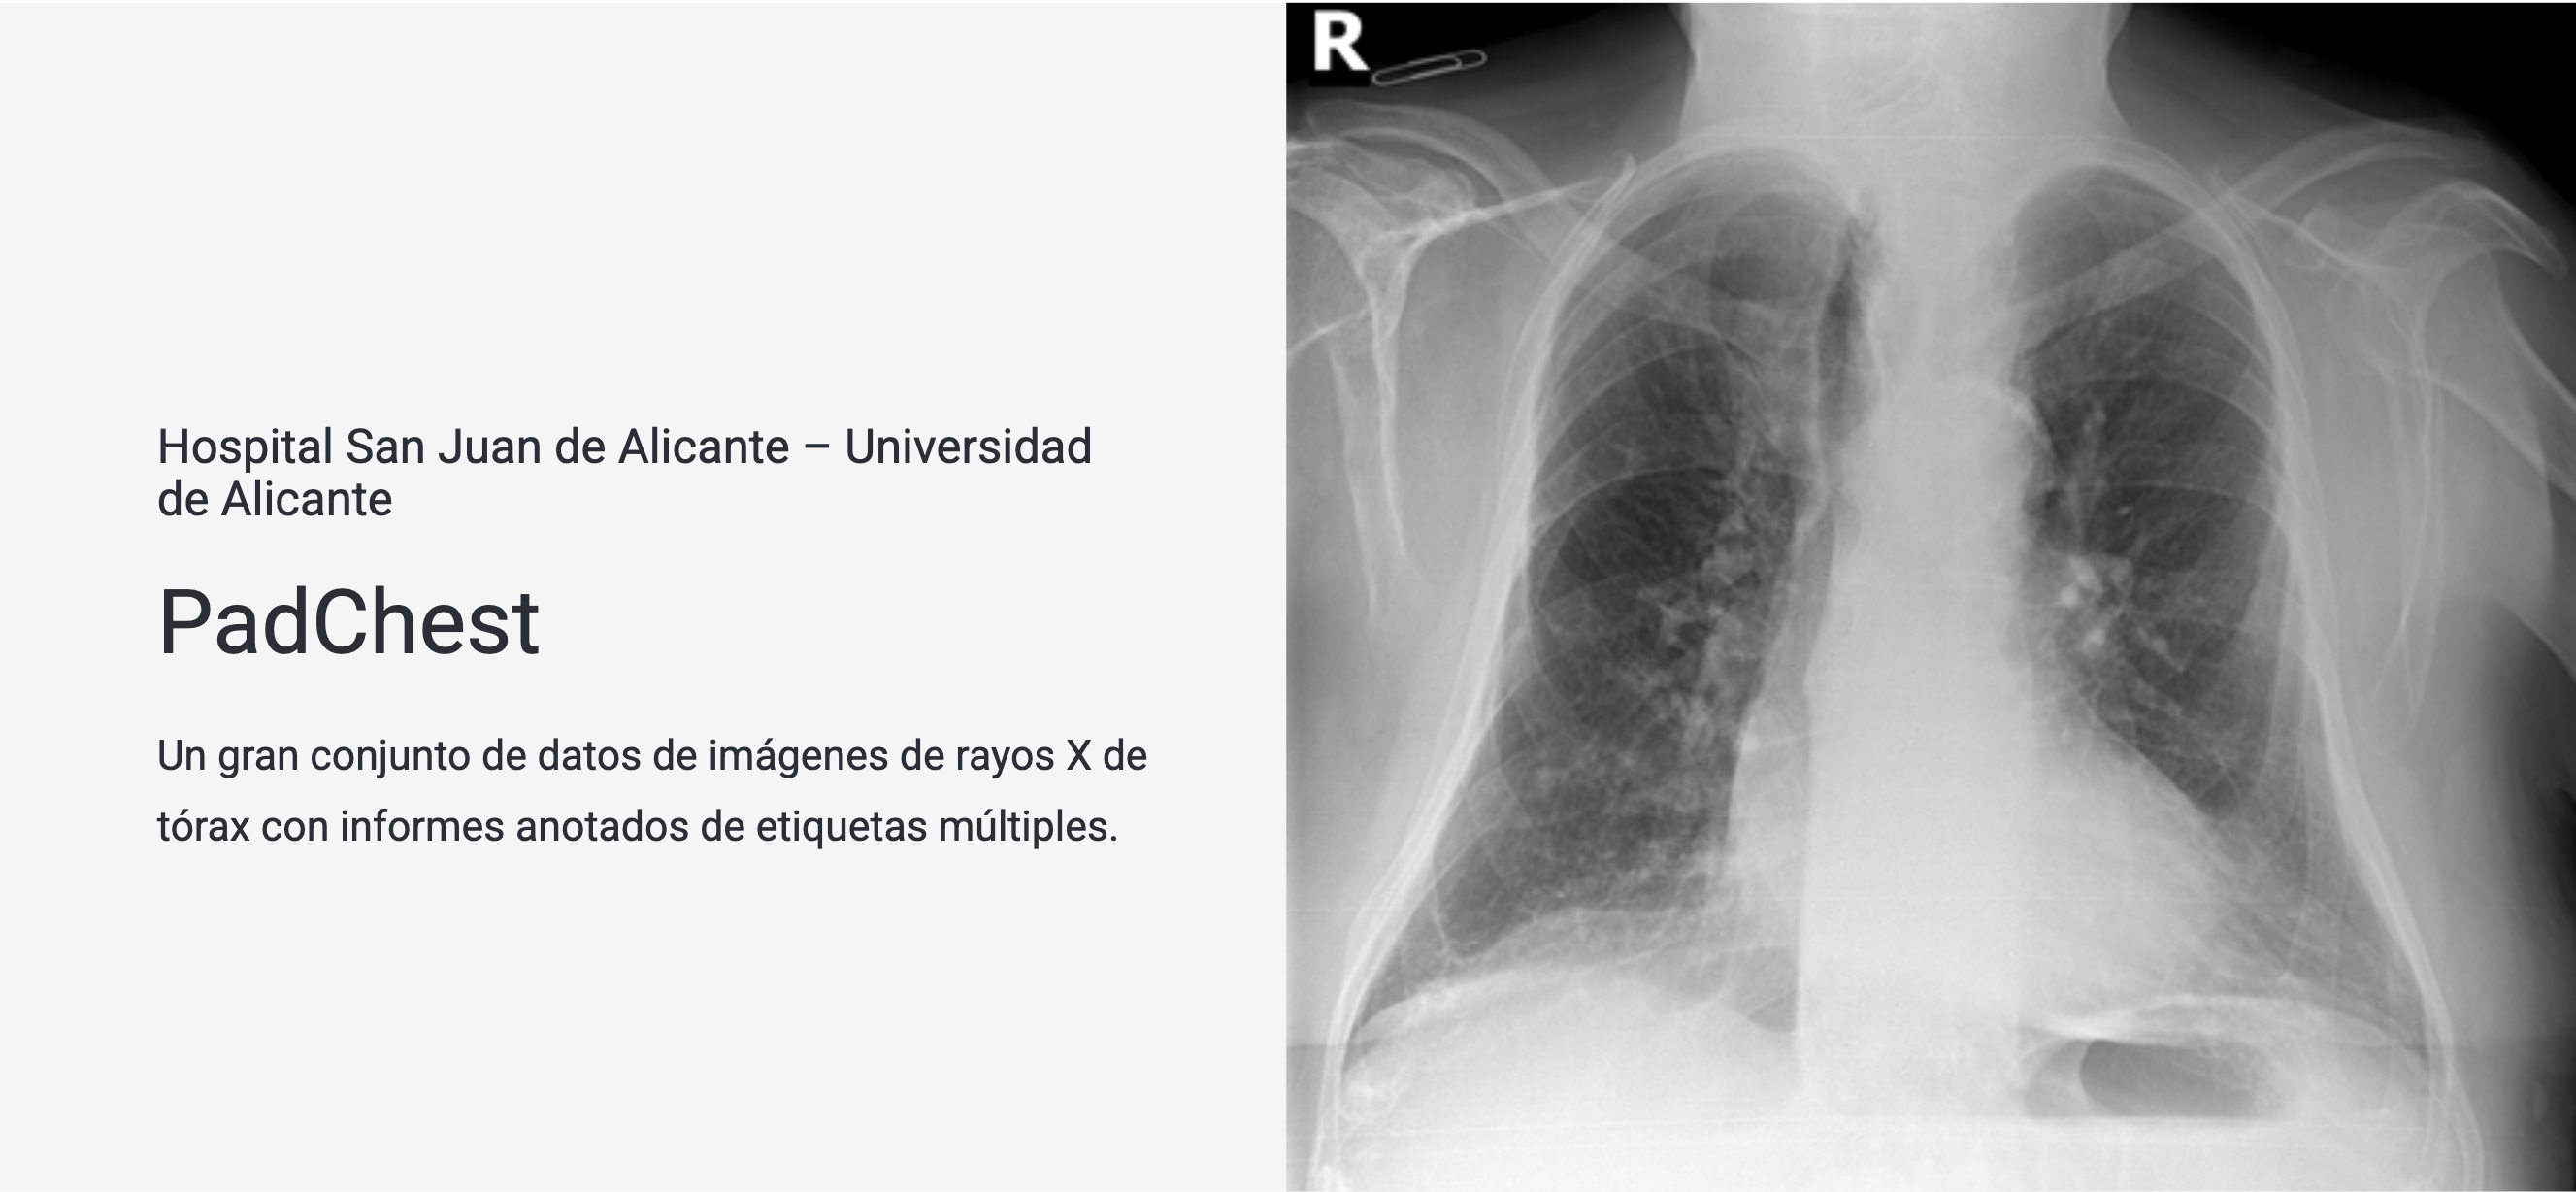

### Carga de librerias necesarias

In [ ]:
## Herramientas generales de manejo de datos, métricas y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import*
from collections import Counter
import requests
import json
import sklearn.metrics as mt
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
import cv2
pd.options.display.max_rows = None
pd.options.display.max_columns = None

## Librerias para construcción de Modelo
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Input,GlobalAveragePooling2D, Dropout,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
import warnings
warnings.filterwarnings('ignore')

## Descarga de token de kaggle que permite acceder al set de datos
json_response= requests.get("https://raw.github.com/HectorHenriquez/Airway_segmentation/main/kaggle.json")
token = json.loads(json_response.text)
with open("kaggle.json", "w") as outfile:
    json.dump(token, outfile)

## Carga de datos desde Kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## Dataset
! kaggle datasets download hshenriquez/chest-x-ray-padchest-sample
!unzip /content/chest-x-ray-padchest-sample.zip

### Definición de funciones que utilizaremos durante el entrenamiento y evaluación

In [ ]:
resnet_radimagenet = '/content/encoder_resnet_Radimagenet.h5'

def translate_label(gt):
    if gt == '1':
        label = 'Patológica'
    else:
        label = 'Normal'
    return(label)

def translate_prediction(pred):
    if pred == 1.0:
        label = 'Patológica'
    else:
        label = 'Normal'
    return(label)

def discretizar_edades(edades, bins=0):
    edades = np.array(edades)

    # Definimos los cortes automáticos si bins es un entero
    if isinstance(bins, int):
        categorias = pd.cut(edades, bins=bins)
    else:
        # Si se pasan cortes manuales
        categorias = pd.cut(edades, bins=bins, include_lowest=True)

    return categorias.astype(str)

def scheduler(epoch, learning_rate):
  if epoch < 5:
    return learning_rate
  else:
    return learning_rate * np.exp(-0.05)

def metrics(y, y_hat):
  tn, fp, fn, tp = confusion_matrix(y, y_hat).ravel()
  tpr = tp/(tp+fn)
  fpr = fp/(tn+fp)
  return (fpr, tpr)

def ROC(y_prob, y):
  tprs = []
  fprs = []
  thresholds = np.linspace(0,1,1000)
  for t in thresholds:
      y_hat = (y_prob >= t).astype('float')
      fpr, tpr = metrics(y, y_hat)
      tprs.append(tpr)
      fprs.append(fpr)
  return (thresholds, np.array(fprs), np.array(tprs))


## Función para generar mapas de activación de clase sobre la predicción.
def MapaActivacion(img_tensor, model, last_conv_layer_name="conv5_block3_out"):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_tensor)

        # binario vs multiclase
        if preds.shape[-1] == 1:  # binary classification
            class_channel = preds[:, 0]
        else:  # multiclass
            pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # normalización
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())

    # resize al tamaño original
    heatmap_array = heatmap.numpy()
    heatmap_resize = cv2.resize(heatmap_array, (img_tensor.shape[2], img_tensor.shape[1]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resize), cv2.COLORMAP_JET)

    return heatmap_array, heatmap_color

def build_transfer_model(input_shape=(128, 128, 1), num_classes=1, dense_layer_units = 128, trainable = False):

    # Define la capa de entrada (1 canal)
    inputs_mono = Input(shape=input_shape)

    # Crea el tensor de 3 canales repitiendo un canal
    inputs_rgb = Concatenate()([inputs_mono, inputs_mono, inputs_mono])

    # Carga el modelo base usando el tensor de 3 canales como entrada
    # ImageNet y RadImageNet funcionan en imágenes de 3 canales (RGB)
    base_model = ResNet50(
        include_top=False,
        weights=resnet_radimagenet,
        input_tensor=inputs_rgb)

    # Congela o entrena el encoder
    base_model.trainable = trainable

    # Añade clasificador
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    #x = Flatten()(x)
    x = Dense(dense_layer_units, activation='relu')(x)
    outputs = Dense(num_classes, activation='sigmoid')(x) ## sigmoid -> clasificacion binaria

    ## Crea el modelo
    model = Model(inputs=inputs_mono, outputs=outputs)
    return model


def augment_image_and_label(image, label):
    # Random flip
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random rotation (90, 180, 270 grados)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)

    # Random zoom (recorte y resize)
    scales = tf.random.uniform(shape=[], minval=0.8, maxval=1.0)
    crop_size = tf.cast(scales * 128, tf.int32)
    image = tf.image.random_crop(image, size=[crop_size, crop_size, 1])
    image = tf.image.resize(image, size=[128, 128])

    return image, label

def get_augmented_dataset(X_train, y_train, batch_size=32, augment=True):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    if augment:
        dataset = dataset.map(augment_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


### Carga de los datos clínicos e imágenes

In [ ]:
## carga de los datos clínicos
data = pd.read_csv('/content/data_padchest_train_test.csv')
data.shape

In [ ]:
## Carga de imágenes y etiquetas

X_train = np.load('/content/X_train128x128s.npy')
data_train = np.load('/content/train_labels128x128s.npy')
X_test = np.load('/content/X_test128x128s.npy')
data_test = np.load('/content/test_labels128x128s.npy')

print(X_train.shape)
print(data_train.shape)
print(X_test.shape)
print(data_test.shape)

In [ ]:
## Vsualización de casos aleatorios
ROWS = 4
fig, axes1 = plt.subplots(ROWS,ROWS,figsize=(10,10))
for j in range(ROWS):
    for k in range(ROWS):
        i = np.random.randint(0, X_train.shape[0])
        label = translate_label(data_train[i,1])
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_train[i,:,:], cmap='gray')
        axes1[j][k].set_title(label)

plt.show()

In [ ]:
## Evaluación de imágenes y etiquetas de caso aleatorio
index = np.random.randint(X_train.shape[0], size=1)
df_retrieve = data[data.ImageID.isin(data_train[index][:,0])].loc[:,['PatientSex_DICOM', 'Age', 'normal', 'neumonia', 'atelectasia',
       'intersticial fibrotico', 'nodulo-masa', 'derrame pleural',
       'neumotorax', 'cardiomegalia', 'alteracion aorta',
       'alteracion mediastino', 'cambios postquirurgicos', 'dispositivos cvc',
       'dispositivos mp', 'dispositivos tubo', 'dispositivos sonda',
       'esqueleto degenerativo', 'lesion osea - fractura', 'otro',
       'calidad deficiente', 'Manufacturer_DICOM']]

label = translate_label(data_train[index,1])

print(df_retrieve)
plt.figure(figsize=(6,6))
plt.imshow(X_train[index].reshape(128,128), cmap='gray')
plt.title(label)
plt.show()

### Preprocesamiento de los datos

In [ ]:
### El formato corresponde a imágenes en color de 8 bit
### Se normalizan dividiendo por 255, lo que deja valores de pixeles entre 0 y 1
### Se cambian a tipo flotante de 32 bits
X_train = (X_train/255).astype('float32')
X_test = (X_test/255).astype('float32')

## Formato de tensor de 4 dimensiones
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2],1)
print(X_train.shape)
print(X_test.shape)

## Construcción y entrenamiento del Modelo 🖥



In [ ]:
### Definición de parámetros de la red neuronal:

trainable = False ## True or False, define si se entrena el encoder

dense_layer_neurons = 128  ## Cantidad de neuronas de la capa de clasificación
EPOCHS = 20 ## Cantidad de épocas de entrenamiento
BATCH_SIZE = 64 ### Cantidad de imágenes que recibe cada iteración
LR = 0.005 ### Tasa de aprendizaje

### Construcción del modelo
model = build_transfer_model(input_shape=(128, 128, 1), num_classes=1, dense_layer_units = dense_layer_neurons, trainable=trainable)


## Reduce la tasa de aprendizaje al avanzar entrenamiento:
lr_scheduler = LearningRateScheduler(scheduler)

checkpoint_filepath = './checkpoint.weights.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## Data Augmentation
augmented_ds = get_augmented_dataset(X_train, data_train[:,1].astype('float32'), batch_size=BATCH_SIZE, augment=True)

## Compilado y entrenamiento
model.compile(optimizer=Adam(learning_rate=LR), loss = 'binary_crossentropy', metrics=['accuracy', AUC()])

history = model.fit(augmented_ds, epochs= EPOCHS, verbose= 1, batch_size= BATCH_SIZE,
                validation_data = [X_test,data_test[:,1].astype('float32') ], shuffle= False,
                callbacks=[model_checkpoint_callback,lr_scheduler])

#history = model.fit(X_train, data_train[:,1].astype('float32'), epochs= EPOCHS, verbose= 1, batch_size= BATCH_SIZE,
#                validation_split = val_split_proportion, shuffle= False,
#                callbacks=[model_checkpoint_callback,lr_scheduler])

model.load_weights(checkpoint_filepath)

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy', color='salmon')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy', color='dodgerblue')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss', color='salmon')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='dodgerblue')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
## Fine Tuning
#EPOCHS = 5 ## Cantidad de épocas de entrenamiento
#BATCH_SIZE = 64 ### Cantidad de imágenes que recibe cada iteración
#LR = 0.00005

#model_ft = build_transfer_model(input_shape=(128, 128, 1), num_classes=1, dense_layer_units = dense_layer_neurons, trainable=True)
## Compilado y entrenamiento
#model_ft.compile(optimizer=Adam(learning_rate=LR), loss = 'binary_crossentropy', metrics=['accuracy', AUC()])
##se cargan
#model_ft.load_weights(checkpoint_filepath)
#history = model_ft.fit(augmented_ds, epochs= EPOCHS, verbose= 1, batch_size= BATCH_SIZE,
#                validation_data = [X_test,data_test[:,1].astype('float32') ], shuffle= False,
#                callbacks=[model_checkpoint_callback,lr_scheduler])
#model_ft.load_weights(checkpoint_filepath)


## Probando el modelo

In [ ]:
pred_scores_train = model.predict(X_train)
pred_scores_test = model.predict(X_test)


In [ ]:
### Graficar ROC Curves
plt.figure(figsize=(12,10))

fpr_train, tpr_train, _ = mt.roc_curve(data_train[:,1].astype('float32'), pred_scores_train, pos_label=1)
auc_train = round(mt.auc(fpr_train,tpr_train),3)
plt.plot(fpr_train, tpr_train,label="AUC data entrenamiento, AUC=" + str(auc_train), color='blueviolet')

fpr_test, tpr_test, _ = mt.roc_curve(data_test[:,1].astype('float32'), pred_scores_test, pos_label=1)
auc_test = round(mt.auc(fpr_test,tpr_test),3)
plt.plot(fpr_test, tpr_test,label="AUC data test, AUC=" + str(auc_test), color='orange')

plt.plot([0,1], [0,1],color='gray', lw=2, linestyle="--")

plt.title('AUC ROC')
plt.legend(fontsize=14)
plt.show()

In [ ]:
## Ajustar umbral del modelo
threshold = 0.5

y_pred_test = np.where(pred_scores_test > threshold, 1, 0)
cm = confusion_matrix(data_test[:,1].astype('float32') , y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'patológico'])
disp.plot(cmap='Blues')
plt.title("Matriz de confusión de grupo test")
plt.show()

### Valores predictivos positivo y negativo
tn, fp, fn, tp = confusion_matrix(data_test[:,1].astype('float32'), y_pred_test).ravel()

VPP = tp / (tp + fp)
VPN = tn / (tn + fn)
TPR = tp / (tp + fn)
FPR = fp / (tn + fp)

print("***")
print(f"Valor Predictivo Positivo: {VPP:.2f}")
print(f"Valor Predictivo Negativo: {VPN:.2f}")
print(f"Tasa de Verdaderos Positivos: {TPR:.2}")
print(f'Tasa de Falsos Positivos: {FPR:.2}')
print("***")

print(classification_report(data_test[:,1].astype('float32'),y_pred_test, target_names = ['normal', 'patológico']))

## Ajustando el umbral del modelo

In [ ]:
### Calculas TPR y FPR para diferentes umbrales
thresholds, fprs, tprs = ROC(pred_scores_test, data_test[:,1].astype('float32'))

# Calculate the optimal threshold and generate predictions y_hat
J = tprs - fprs
optimal_threshold = thresholds[np.argmax(J)]

### TPR y FPR para este umbral
fpr = fprs[np.argmax(J)]
tpr = tprs[np.argmax(J)]


print(f"Umbral óptimo:{optimal_threshold:.2f}")
print(f'TPR : {tpr:.2f}')
print(f'FPR : {fpr:.2f} ')


In [ ]:
### Aplicamos umbral óptimo
y_pred_test_bin = (pred_scores_test >= optimal_threshold).astype('float')

## Nueva matriz de confusión con umbral óptimo
cm = confusion_matrix(data_test[:,1].astype('float32') , y_pred_test_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'patológico'])
disp.plot(cmap='Blues')
plt.title("Matriz de confusión de grupo test")
plt.show()

### Valores predictivos positivo y negativo
tn, fp, fn, tp = confusion_matrix(data_test[:,1].astype('float32'), y_pred_test_bin).ravel()

VPP = tp / (tp + fp)
VPN = tn / (tn + fn)
TPR = tp / (tp + fn)
FPR = fp / (tn + fp)

print("***")
print(f"Valor Predictivo Positivo: {VPP:.2f}")
print(f"Valor Predictivo Negativo: {VPN:.2f}")
print(f"Tasa de Verdaderos Positivos: {TPR:.2}")
print(f'Tasa de Falsos Positivos: {FPR:.2}')
print("***")

### Otras métricas
print(classification_report(data_test[:,1].astype('float32'), y_pred_test_bin, target_names = ['normal', 'patológico']))


## Probando el Modelo

In [ ]:
index = np.random.randint(0, X_test.shape[0])
image_case = str(data_test[index,0])

df_retrieve = data[data.ImageID.isin([image_case])].loc[:,['ImageID', 'normal', 'neumonia', 'atelectasia',
       'intersticial fibrotico', 'nodulo-masa', 'derrame pleural',
       'neumotorax', 'cardiomegalia', 'alteracion aorta',
       'alteracion mediastino', 'cambios postquirurgicos', 'dispositivos cvc',
       'dispositivos mp', 'dispositivos tubo', 'dispositivos sonda',
       'esqueleto degenerativo', 'lesion osea - fractura', 'otro']]

img_to_explain = X_test[index,:,:,:]
img_to_array = np.expand_dims(img_to_explain, axis=0)
pred_scores = model.predict(img_to_array)
pred_scores_bin = np.where(pred_scores > 0.5, 1.0, 0.0)

heatmap_array, heatmpap_resized = MapaActivacion(img_to_array, model)

print(df_retrieve.head(1))
f = plt.figure(figsize=(12,12), frameon=True)
f.add_subplot(1, 2, 1)
plt.imshow(img_to_explain.reshape(128,128), cmap='gray')
plt.imshow(heatmpap_resized, alpha=0.4, cmap='jet')
plt.title("Predicción Modelo:{}".format(translate_prediction(pred_scores_bin)))

f.add_subplot(1, 2, 2)
plt.imshow(img_to_explain, cmap='gray')
plt.title('X-Ray')
plt.show()

## Evaluación del modelo

In [ ]:
## Se crea un set de datos que tenga la información demográfica, las respuestas y predicciones
df_evaluacion = pd.DataFrame()

df_evaluacion['ImageID'] = data_test[:,0]
df_evaluacion['Label'] = data_test[:,1].astype('int64')
df_evaluacion['Prediccion'] = y_pred_test_bin

df_test = data[data.ImageID.isin(data_test[:,0])].loc[:,['ImageID', 'Age', 'PatientSex_DICOM','Manufacturer_DICOM','calidad deficiente']]
df_test_evaluacion = pd.merge(df_test, df_evaluacion, on='ImageID')

### Ejercicio de comparación de rendimiento por sexo

In [ ]:
### Diferencia por sexo
fpr_male, tpr_male = metrics(df_test_evaluacion[df_test_evaluacion.PatientSex_DICOM == 'M'].Label,df_test_evaluacion[df_test_evaluacion.PatientSex_DICOM == 'M'].Prediccion)

fpr_female, tpr_female = metrics(df_test_evaluacion[df_test_evaluacion.PatientSex_DICOM == 'F'].Label,df_test_evaluacion[df_test_evaluacion.PatientSex_DICOM == 'F'].Prediccion)

### Delta TPR y Delta FPR:

delta_tpr = abs(tpr_male - tpr_female)
delta_fpr = abs(fpr_female - fpr_female)

print(f"TPR hombres: {tpr_male:.2f}")
print(f"TPR mujeres: {tpr_female:.2f}")
print(f"FPR hombres: {fpr_male:.2f}")
print(f"FPR mujeres: {fpr_female:.2f}")
print("####"*3)
print(f"Delta TPR: {delta_tpr:.2f}")
print(f"Delta FPR: {delta_fpr:.2f}")

## Evaluación de subgrupos

In [ ]:
# Evaluación por edad
print("Edad mínima:", df_test_evaluacion.Age.min())
print("Edad máxima:", df_test_evaluacion.Age.max())

bins_cortes = [0.1,15,30,50,70,80,90,115]
categoria_edades = discretizar_edades(df_test_evaluacion.Age, bins=bins_cortes)
df_test_evaluacion ['rango de edad'] = categoria_edades

vector_edad_corregido = np.where(df_test_evaluacion['rango de edad'] == '(70.0, 80.0]', '70 a 80 años', df_test_evaluacion['rango de edad'])
vector_edad_corregido = np.where(vector_edad_corregido== '(90.0, 115.0]', '90 a 115 años', vector_edad_corregido)
vector_edad_corregido = np.where(vector_edad_corregido== '(50.0, 70.0]', '50 a 70 años', vector_edad_corregido)
vector_edad_corregido = np.where(vector_edad_corregido== '(80.0, 90.0]', '80 a 90 años', vector_edad_corregido)
vector_edad_corregido = np.where(vector_edad_corregido== '(15.0, 30.0]', '15 a 30 años', vector_edad_corregido)
vector_edad_corregido = np.where(vector_edad_corregido== '(30.0, 50.0]', '30 a 50 años', vector_edad_corregido)
vector_edad_corregido = np.where(vector_edad_corregido== '(0.099, 15.0]','0 a 15 años]', vector_edad_corregido)
df_test_evaluacion ['rango de edad']  = vector_edad_corregido

In [ ]:
variables_evaluar = ['PatientSex_DICOM', 'Manufacturer_DICOM', 'calidad deficiente']

dic_results = {}

for rango in df_test_evaluacion['rango de edad'].unique():
    dic_results[rango] = {}
    df_temp = df_test_evaluacion[df_test_evaluacion['rango de edad'] == rango]
    for var in variables_evaluar:
        dic_results[rango][var] = {}
        for i in range(len(df_temp[var].unique())):
            cat = df_test_evaluacion[var].unique()[i]
            df_temp_auc = df_temp[df_temp[var] == cat]
            fpr, tpr, _ = mt.roc_curve(df_temp_auc.Label,df_temp_auc.Prediccion, pos_label=1)
            auc = round(mt.auc(fpr,tpr),3)
            dic_results[rango][var][cat] = auc

vector_rangos = []
vector_auc = []
vector_caracteristica = []
vector_subcaracteristica = []

for rango in dic_results.keys():
    for caracteristica in dic_results[rango].keys():
        for subcaracteristica in dic_results[rango][caracteristica].keys():
            vector_rangos.append(rango)
            vector_auc.append(dic_results[rango][caracteristica][subcaracteristica])
            vector_caracteristica.append(caracteristica)
            vector_subcaracteristica.append(subcaracteristica)

df_total_test = pd.DataFrame()
df_total_test['rango de edad'] = vector_rangos
df_total_test['AUC'] = vector_auc
df_total_test['caracteristica'] = vector_caracteristica
df_total_test['clase'] = vector_subcaracteristica

vector_clase_corregido = np.where(df_total_test.clase == 'F', 'PatientSex: Female', df_total_test.clase)
vector_clase_corregido = np.where(vector_clase_corregido == 'M', 'PatientSex: Male', vector_clase_corregido)
vector_clase_corregido = np.where(vector_clase_corregido == 'ImagingDynamicsCompanyLtd', 'Brand: ImagingDynamicsCompanyLtd', vector_clase_corregido)
vector_clase_corregido = np.where(vector_clase_corregido == 'PhilipsMedicalSystems', 'Brand: PhilipsMedicalSystems', vector_clase_corregido)
vector_clase_corregido = np.where(vector_clase_corregido == 0.0, 'Calidad técnica adecuada', vector_clase_corregido)
vector_clase_corregido = np.where(vector_clase_corregido == 1.0, 'Calidad técnica deficiente', vector_clase_corregido)

df_total_test['categoria'] = vector_clase_corregido

(
ggplot(df_total_test[df_total_test.caracteristica !='calidad deficiente'])+
    aes(x='rango de edad', y='AUC', fill= 'categoria') +
    geom_col(stat ='identity', position='dodge', alpha=0.8) +
    theme_bw() +
    scale_y_continuous(breaks = np.arange(0,105, 5) /100)+
    scale_fill_manual( values=['dodgerblue','lightskyblue','blueviolet','sienna'])+
    labs(title='Análisis del rendimiento del modelo por subgrupos', x='Rangos de edad')+
    theme(figure_size=(14,6))

)